# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos.
Necesitamos atraer a más conductores durante las horas pico para predecir la cantidad de pedidos de taxis para la próxima hora. Construiremos un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descargaremos los datos y haremos el remuestreo por una hora.
2. Analizaremos los datos
3. Entrenaremos diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
4. Probaremos los datos usando la muestra de prueba y proporcionaremos una conclusión.


## Descripción de los datos

- Los datos se almacenan en el archivo `taxi.csv`. 	
- El número de pedidos está en la columna `'num_orders'`.

# Preparación

##  Importamos librerias y cargamos datos

In [14]:
!pip install lightgbm


                                              0.0/1.4 MB ? eta -:--:--
                                              0.0/1.4 MB 330.3 kB/s eta 0:00:05
                                              0.0/1.4 MB 330.3 kB/s eta 0:00:05
     -                                        0.1/1.4 MB 469.7 kB/s eta 0:00:03
     ---                                      0.1/1.4 MB 656.4 kB/s eta 0:00:03
     ----                                     0.2/1.4 MB 706.2 kB/s eta 0:00:02
     ------                                   0.2/1.4 MB 811.5 kB/s eta 0:00:02
     -------                                  0.3/1.4 MB 827.5 kB/s eta 0:00:02
     -------                                  0.3/1.4 MB 842.9 kB/s eta 0:00:02
     ---------                                0.3/1.4 MB 840.2 kB/s eta 0:00:02
     ---------                                0.4/1.4 MB 857.5 kB/s eta 0:00:02
     ----------                               0.4/1.4 MB 836.4 kB/s eta 0:00:02
     -----------                              0.4

In [15]:
!pip install xgboost


                                              0.0/124.9 MB ? eta -:--:--
                                            0.0/124.9 MB 991.0 kB/s eta 0:02:07
                                            0.1/124.9 MB 825.8 kB/s eta 0:02:32
                                              0.2/124.9 MB 1.7 MB/s eta 0:01:14
                                              0.4/124.9 MB 2.4 MB/s eta 0:00:52
                                              0.6/124.9 MB 3.2 MB/s eta 0:00:40
                                              1.0/124.9 MB 4.4 MB/s eta 0:00:29
                                              1.5/124.9 MB 5.2 MB/s eta 0:00:24
                                              1.9/124.9 MB 6.2 MB/s eta 0:00:20
                                              1.9/124.9 MB 6.2 MB/s eta 0:00:20
                                              3.0/124.9 MB 7.3 MB/s eta 0:00:17
     -                                        3.3/124.9 MB 7.2 MB/s eta 0:00:17
     -                                        3

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit


from sklearn.metrics import mean_squared_error, make_scorer, r2_score
import lightgbm as lgb
import xgboost as xgb

In [17]:
#cargamos el dataset
data = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Este código lee un archivo .csv que contiene los datos de taxis, utilizaremos la primera columna como el índice del DataFrame, y corregiremos su tipo de valores a datetime.

Nota: Nos dimos cuenta al ver los datos por eso decidimos cargar el dataset de esa manera!!

## Análisis Exploratorio de los Datos

In [18]:
#vemos una muestra de los datos
data.head(7)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7


In [19]:
#ahora una informacion general de los datos
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [20]:
data.shape

(26496, 1)

In [21]:
#revisamos que las fechas y las horas si se encuentren en orden cronológico
data.index.is_monotonic_increasing

True

In [22]:
#remuestrear los datos de tal forma que cada punto de datos de los datos originales caigan dentro de intervalos de una hora 
data = data.resample('1H').sum()

In [23]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Podemos ver una tabla con 4416 filas el indice es la fecha con su respectivos intervalos de una hora y una sola columna con el número de ordenes inicia del **01/03/2018 al 31/08/2018**

## Visualizaremos nuestros datos para encontrar posibles patrones

<Axes: xlabel='datetime'>

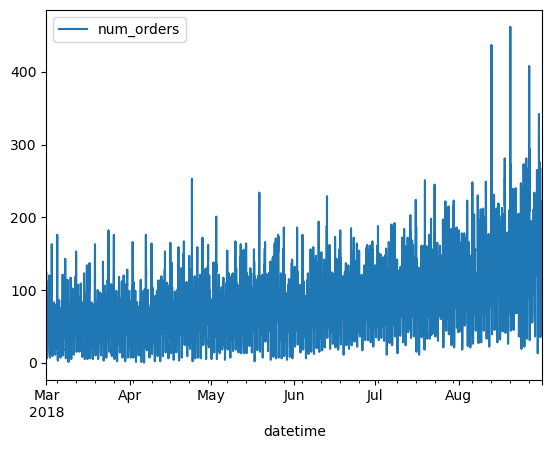

In [25]:
#visualizaremos los datos para identificar cualquier irregularidad obvia
data.plot()

## Prueba ADF

Realizaremos pruebas para determinar si nuestra serie temporal es estacionaria o no es estacionaria... realizando una prueba ADF

In [26]:
#Realizamos la prueba ADF:
result = adfuller(data['num_orders'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critical Value (%s): %.3f' % (key, value))


ADF Statistic: -3.0689242890279544
p-value: 0.02894005140261296
Critical Value (1%): -3.432
Critical Value (5%): -2.862
Critical Value (10%): -2.567


Dado que la estadística ADF es mucho menor que los valores críticos y el valor p es significativamente bajo (0.0), podemos concluir que la serie temporal 'num_orders' **es estacionaria.**

Esto significa que las propiedades estadísticas de la serie, como la media y la varianza, son constantes en el tiempo, lo que es una condición deseable para muchos modelos de series temporales.

## Decompose

In [27]:
decomposed = seasonal_decompose(data)

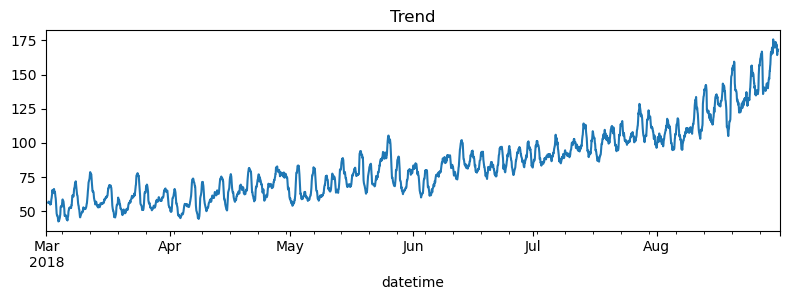

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.tight_layout()

## Agregando nuevas características y reduciendo fluctuaciones para nuestro modelo

In [29]:
#Vamos a usar la media móvil para reducir las fluctuaciones en la serie temporal 
data['rolling_mean'] = data.rolling(10).mean()


In [30]:
data['std'] = data['num_orders'].rolling(10).std()

<Axes: xlabel='datetime'>

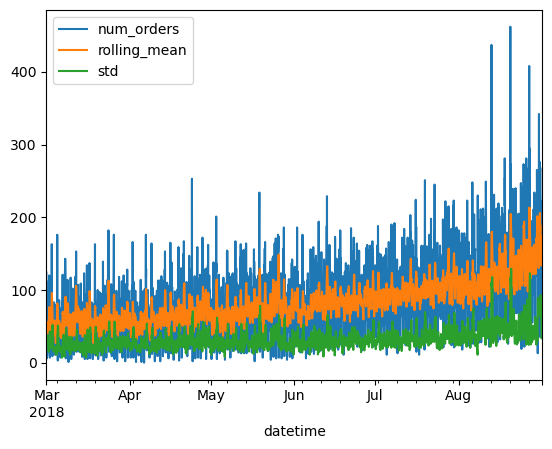

In [31]:
data.plot()

In [32]:
data -=data.shift()

<Axes: xlabel='datetime'>

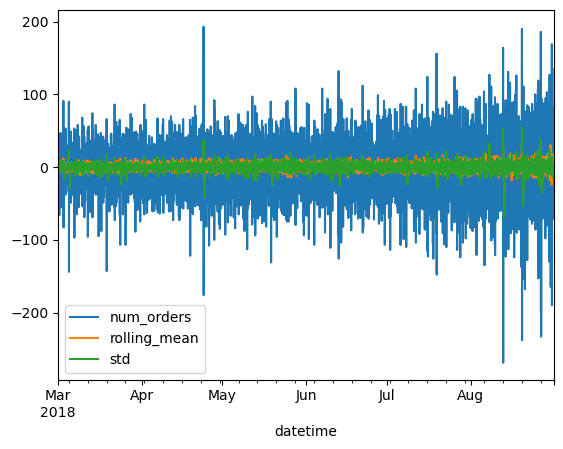

In [33]:
data.plot()

Vamos a crear características de tiempo

In [34]:
# Crear características de tiempo
data['hour'] = data.index.hour
data['day'] = data.index.day
data['month'] = data.index.month

Podemos ver una muestra de nuestra nueva tabla con las caracteristicas ya agregadas

In [35]:
data.head()

,num_orders,rolling_mean,std,hour,day,month
datetime,,,,,,
2018-03-01 00:00:00,NaN,NaN,NaN,0,1,3
2018-03-01 01:00:00,-39.0,NaN,NaN,1,1,3
2018-03-01 02:00:00,-14.0,NaN,NaN,2,1,3
2018-03-01 03:00:00,-5.0,NaN,NaN,3,1,3
2018-03-01 04:00:00,-23.0,NaN,NaN,4,1,3


In [36]:
# Crear características de retrasos (lags)
for lag in range(1, 25):
    data[f'lag_{lag}'] = data['num_orders'].shift(lag)


In [37]:
# Eliminar filas con valores NaN
data = data.dropna()

# Formación

## División de Datos en Conjuntos de Entrenamiento y Prueba

In [38]:
# Definir las características y el objetivo
X = data.drop(columns=['num_orders'])
y = data['num_orders']


In [39]:
# Dividir los datos en entrenamiento (90%) y prueba (10%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [40]:
print(X_train.index.min(), X_train.index.max())
print(X_test.index.min(), X_test.index.max())

2018-03-02 01:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


## Entrenamiento del Modelo

### Regresión Lineal

In [41]:
# Crear y entrenar el modelo de regresión lineal
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [49]:
# Realizar predicciones
y_pred_lr = model_lr.predict(X_test)

In [50]:
# Evaluar el modelo
rmse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(rmse_lr)

### RandomForest

In [42]:
# Crear y entrenar el modelo de bosque aleatorio
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)


RandomForestRegressor()

In [44]:
# Realizar predicciones
y_pred_rf = model_rf.predict(X_test)

In [51]:
# Evaluar el modelo
rmse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(rmse_rf)

**RECM de ambos modelos**

In [52]:
print(f"RMSE Linear Regression: {rmse_lr}")
print(f"RMSE Random Forest: {rmse_rf}")

RMSE Linear Regression: 1.942419354756818e-13
RMSE Random Forest: 35.710954271763725


## Probar modelos de boosting

### LightGBM

In [55]:
# Crear y entrenar el modelo LightGBM
model_lgb = lgb.LGBMRegressor()
model_lgb.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5038
[LightGBM] [Info] Number of data points in the train set: 3951, number of used features: 29
[LightGBM] [Info] Start training from score 0.021514


C:\Users\T3R4BYT3\anaconda3\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


LGBMRegressor()

In [57]:
# Realizar predicciones
y_pred_lgb = model_lgb.predict(X_test)

In [59]:
# Evaluar el modelo con RECM
rmse_lgb = mean_squared_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(rmse_lgb)

### XGBoost

In [61]:
!pip install --upgrade scikit-learn xgboost

In [72]:
# Crear el modelo
model_xgb = xgb.XGBRegressor()

In [73]:
# entrenar el modelo
model_xgb.fit(X_train, y_train)

C:\Users\T3R4BYT3\anaconda3\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [74]:
# Realizar predicciones
y_pred_xgb = model_xgb.predict(X_test)

In [75]:
# Evaluar el modelo con el RECM
rmse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(rmse_xgb)

In [76]:
print(f"RMSE LightGBM: {rmse_lgb}")
print(f"RMSE XGBoost: {rmse_xgb}")

RMSE LightGBM: 30.34250161572144
RMSE XGBoost: 31.137067990809676


## Prueba

In [68]:
# Crear un DataFrame con los resultados
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'LightGBM', 'XGBoost'],
    'RMSE': [rmse_lr, rmse_rf, rmse_lgb, rmse_xgb]
})

results

,Model,RMSE
0,Linear Regression,1.942419e-13
1,Random Forest,3.571095e+01
2,LightGBM,3.034250e+01
3,XGBoost,3.113707e+01


# Conclusion

- Realizamos un EDA y preprocesamos los datos como agregando nuevas caracteristicas a nuestro modelo reduciendo fluctuaciones y poniendo nuestra serie temporal en intervalos de una hora 

- Eliminamos los valores ausentes que se generaron

- Definimos nuestras caracteristicas y el objetivo a predecir, dividimos nuestro conjunto de datos en un conjunto de entrenamiento del 90% y de prueba del 10% de manera ordenada haciendo que el 10% fueran los ultimos datos de nuestra serie temporal!!

- Finalmente creamos una tabla con sus respectivas métricas para comparar los modelos, quedando como el mejor modelo:
**Regresion Lineal con un RECM de 19.4219, seguido de LightGBM de 30.34250**

